In [96]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import salishsea_tools.viz_tools as sa_vi
import cmocean.cm as cm


In [101]:
ds = xr.open_dataset ('/results2/SalishSea/nowcast-green.202111/31oct22/SalishSea_1d_20221031_20221031_grid_T.nc')
ds



temp = ds.votemper 

test = test.fillna(0)
a = test.values.flatten()
a = np.transpose(a)
temp_som = SOM(m=3, n=3, dim=1)
temp_som.fit(a)

ValueError: non-broadcastable output operand with shape (9,1) doesn't match the broadcast shape (9,9)

In [88]:
predictions = temp_som.predict(a)

AssertionError: X should have two dimensions, not 1

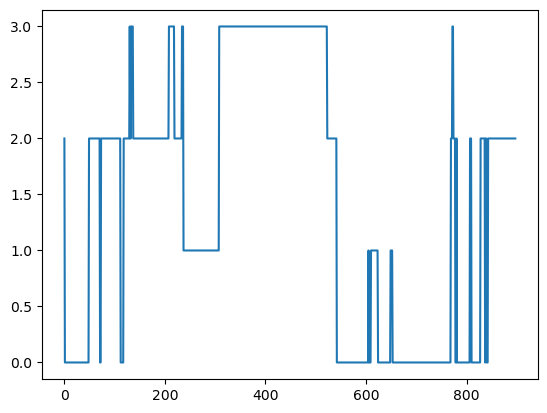

In [66]:
plt.plot(predictions)